## Пример использования внешних словарей в скоре и регуляризаторе когерентности

#### Парсим входную коллекцию в формате Vowpal Wabbit

In [3]:
import artm.messages_pb2, artm.library
parser_config = artm.messages_pb2.CollectionParserConfig()
parser_config.format = artm.library.CollectionParserConfig_Format_VowpalWabbit
parser_config.dictionary_file_name = 'dictionary'
parser_config.docword_file_path = '../datasets/mmro/vw.mmro.txt'
parser_config.target_folder = '../datasets/mmro'
# нарезаем ее на батчи, в каждом из которых будет всего по 100 документов (т.к. коллекция маленькая)
parser_config.num_items_per_batch = 100
artm.library.Library().ParseCollection(collection_parser_config = parser_config)

#### Парсим словрь с внешней информацией о близости слов

In [4]:
import artm.messages_pb2, artm.library
parser_config = artm.messages_pb2.CollectionParserConfig()
# Если матрица взаимной близости слов симметрична, то можно задать только половину ее значений, 
# остальные достроятся сами по флагу use_symmetric_cooc_values = True 
# Если матрица несимметрична, и ничего достраивать не надо, то нужно указать False
parser_config.use_symmetric_cooc_values = True 
# По умолчанию bigARTM cчитает, что все индексы начинаются с 1, в моем файле словаря - с 0
parser_config.use_unity_based_indices = False
parser_config.format = artm.library.CollectionParserConfig_Format_Cooccurrence
parser_config.dictionary_file_name = 'pPMI_w100_dictionary'
# файл со строками вида id1 id2 PMI
parser_config.docword_file_path = '../datasets/mmro/pPMI_w100.mmro.txt'
# файл со словами словаря, упорядоченными по id
parser_config.vocab_file_path = '../datasets/mmro/vocab.mmro.txt'
parser_config.target_folder = '../datasets/mmro'
artm.library.Library().ParseCollection(collection_parser_config = parser_config)

#### Входную коллекцию можно было бы парсить не из VW, а из формата мешков слов UCI

In [24]:
import artm.messages_pb2, artm.library
parser_config = artm.messages_pb2.CollectionParserConfig()
parser_config.format = artm.library.CollectionParserConfig_Format_BagOfWordsUci
parser_config.dictionary_file_name = 'dictionary'
parser_config.docword_file_path = '../datasets/mmro/docword.mmro.txt'
parser_config.vocab_file_path = '../datasets/mmro/vocab.mmro.txt'
parser_config.target_folder = '../datasets'
parser_config.num_items_per_batch = 100
artm.library.Library().ParseCollection(collection_parser_config = parser_config)

#### Определим под себя дополнительные функции для того, чтобы потом в одну строчку обучать разные модели

Коллекция: ММРО-ИОИ, документов: 1061, слов в словаре: 7805 (tex->текст, лемматизация и выкидывание стоп-слов и редких слов). 
Число тем: 50 предметных + 10 фоновых. Для каждой модели считаю набор привычных метрик и рисую на 3 графиках.

In [14]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt
import artm

# путь к созданным батчам коллекции
batch_vectorizer = artm.BatchVectorizer(data_path='../datasets/mmro', data_format='batches')

# задаем темам имена, чтобы иметь возможность применять разные регуляризаторы к подмножествам тем
background_topics = []
domain_topics = []
all_topics = []

for i in range(0, 60):
    if i < 50:
        topic_name = "d" + str(i)
        domain_topics.append(topic_name)
    else:
        topic_name = "b" + str(i)
        background_topics.append(topic_name)
    all_topics.append(topic_name)
        
def prepare(model):
    # это просто словарь слов, которые должны войти в матрицу Фи, он создался автоматически при создании батчей
    model.load_dictionary(dictionary_name='dictionary', dictionary_path='../datasets/mmro/dictionary')
    model.initialize(dictionary_name='dictionary')
    # а это словарь совместной информации, который мы парсили отдельно
    model.load_dictionary(dictionary_name='pPMI_w100_dictionary', dictionary_path='../datasets/mmro/pPMI_w100_dictionary')
 
    # добавляем кучу скоров модели, которые нас будут интересовать
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                      use_unigram_document_model=False, # где-то сохраняется, сколько раз pwd = 0?
                                      dictionary_name='dictionary'))

    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', 
                                           topic_names = domain_topics))

    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore', 
                                            topic_names = domain_topics))

    # если в скоре топ-слов указан словарь, то в числе прочего будет подсчитана когерентность по этому словарю
    model.scores.add(artm.TopTokensScore(name='DomainTop10TokensScore', 
                                         num_tokens=10, 
                                         dictionary_name = 'pPMI_w100_dictionary',
                                         topic_names = domain_topics))

    model.scores.add(artm.TopTokensScore(name='DomainTop100TokensScore', 
                                         num_tokens=100, 
                                         dictionary_name = 'pPMI_w100_dictionary',
                                         topic_names = domain_topics))

    model.scores.add(artm.TopTokensScore(name='BackgroundTopTokensScore', 
                                         num_tokens=10, 
                                         topic_names = background_topics))

    # кроме того, можно подсчитать когерентность "ядра темы"
    model.scores.add(artm.TopicKernelScore(name='DomainTopicKernelScore', 
                                           probability_mass_threshold=0.25, 
                                           dictionary_name = 'pPMI_w100_dictionary',
                                           topic_names = domain_topics))

    model.scores.add(artm.TopicKernelScore(name='BackgroundTopicKernelScore', 
                                           probability_mass_threshold=0.25, 
                                           topic_names = background_topics))
    
    model.scores.add(artm.TopicMassPhiScore(name='BackgroundMassScore',  
                                           topic_names = background_topics))

    
# договариваемся с matplotlib, как будем рисовать графики
def figures(model):
    # perplexity
    x = range(model.num_phi_updates)[1:]
    fig, ax1 = plt.subplots()
    ax1.plot(x, model.score_tracker['PerplexityScore'].value[1:], 'g-', linewidth=2, label="Perplexity")
    ax1.set_xlabel('Iterations count')
    ax1.set_ylabel('Perplexity', color='g')
    ax2 = ax1.twinx()
    ax2.plot(x, model.score_tracker['SparsityPhiScore'].value[1:], 'r*', linewidth=2, label="Phi sparsity")
    ax2.plot(x, model.score_tracker['SparsityThetaScore'].value[1:], 'r--', linewidth=2, label="Theta sparsity")
    #ax2.plot(x, model.score_tracker['BackgroundMassScore'].value[1:], 'r^', linewidth=2, label="Background ratio")
    ax2.set_ylabel('Ratio', color='r')
    ax2.legend(bbox_to_anchor=(1.10, 1), loc=2, borderaxespad=0.)
    plt.grid(True)
    plt.show()
    
    # kernels
    x = range(model.num_phi_updates)[1:]
    fig, ax1 = plt.subplots()
    ax1.plot(x, model.score_tracker['DomainTopicKernelScore'].average_size[1:], 'g-', linewidth=2, label="size")
    ax1.set_xlabel('Iterations count')
    ax1.set_ylabel('Size', color='g')
    ax2 = ax1.twinx()
    ax2.plot(x, model.score_tracker['DomainTopicKernelScore'].average_contrast[1:], 'r*', linewidth=2, label="contrast")
    ax2.plot(x, model.score_tracker['DomainTopicKernelScore'].average_purity[1:], 'r--', linewidth=2, label="purity")
    ax2.set_ylabel('Ratio', color='r')
    ax2.legend(bbox_to_anchor=(1.10, 1), loc=2, borderaxespad=0.)
    plt.grid(True)
    plt.show()
    
    # coherence
    x = range(model.num_phi_updates)[1:]
    plt.plot(x, model.score_tracker['DomainTop10TokensScore'].average_coherence[1:], 'b--', label="top10", linewidth=2)
    plt.plot(x, model.score_tracker['DomainTop100TokensScore'].average_coherence[1:], 'r--', label="top100", linewidth=2)
    plt.plot(x, model.score_tracker['DomainTopicKernelScore'].average_coherence[1:], 'g--', label="kernel", linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('Average coherence')
    plt.legend(bbox_to_anchor=(1.10, 1), loc=2, borderaxespad=0.)
    plt.grid(True)
    plt.show()       

#### Обучение PLSA модели

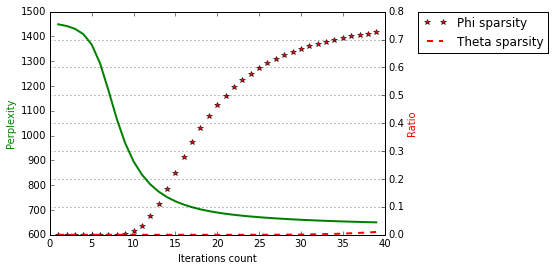

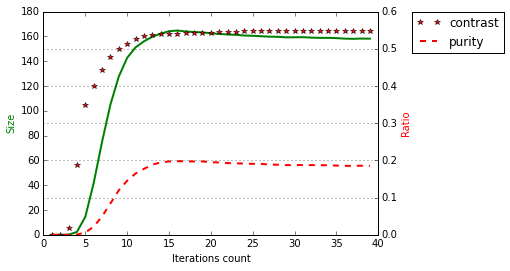

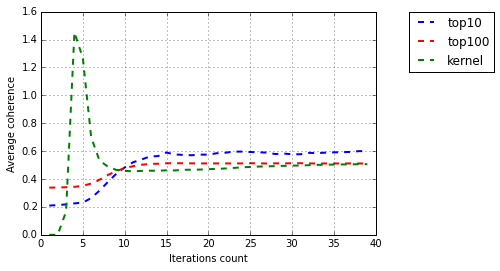

In [15]:
model = artm.ARTM(topic_names = all_topics)
prepare(model)
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)
figures(model)

#### Обучение модели с регуляризаторами сглаживания, разреживания и декоррелирования

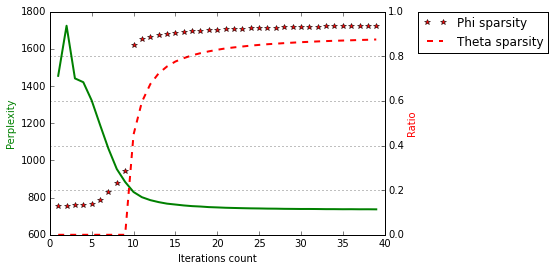

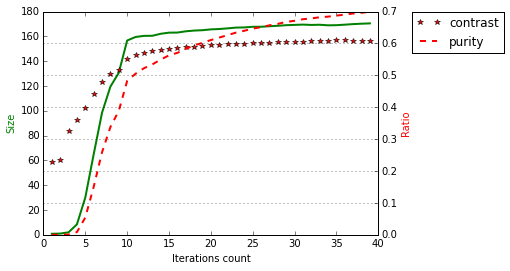

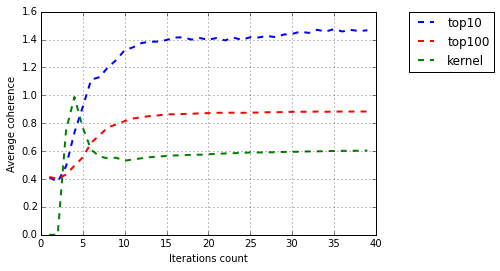

In [16]:
model = artm.ARTM(topic_names = all_topics)
prepare(model)
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SmoothTheta', tau=0.1, topic_names=background_topics))
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau=0.1, topic_names=background_topics))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1e+5, topic_names=domain_topics))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5, topic_names=domain_topics))
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.5, topic_names=domain_topics))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)
figures(model)

#### Добавление регуляризатора, учитывающего PMI-словарь

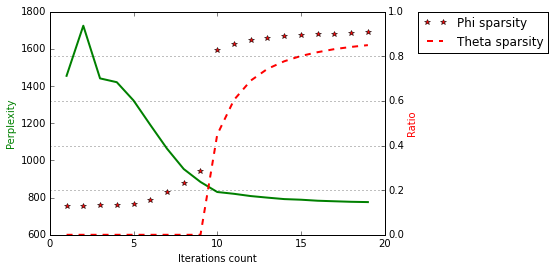

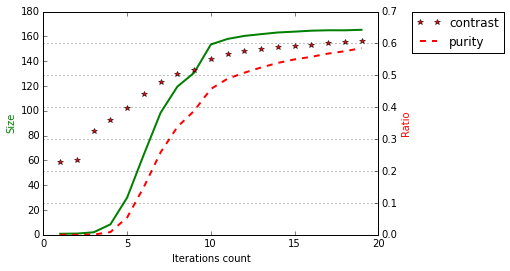

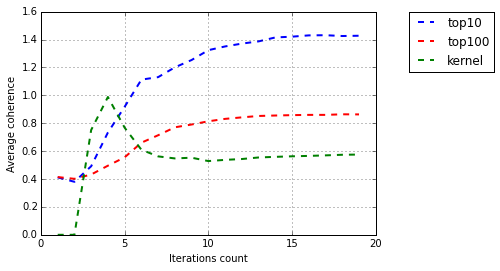

In [18]:
# Пример того, как не получается с pPMI_w100 в ImproveCoherence
model = artm.ARTM(topic_names = all_topics)
prepare(model)
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SmoothTheta', tau=0.1, topic_names=background_topics))
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau=0.1, topic_names=background_topics))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1e+5, topic_names=domain_topics))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)
# вот он, на выход кушает коэффициент и словарь:
model.regularizers.add(artm.ImproveCoherencePhiRegularizer(name='Coherence', tau=0.0001, dictionary_name='pPMI_w100_dictionary'))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5, topic_names=domain_topics))
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.5, topic_names=domain_topics))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)
figures(model)

#### Сохранение результатов

In [21]:
import pandas
phi = model.phi_.sort(axis=0)
theta = model.fit_transform().sort(axis=1)

import numpy as np
np.save("theta", theta.as_matrix())
np.save("phi", phi.as_matrix())

In [22]:
for topic_name in domain_topics:
    print topic_name + ': ',
    tokens = model.score_tracker['DomainTop10TokensScore'].last_topic_info[topic_name].tokens
    for token in tokens:
        print token,
    print

d0:  контур эталон индикатор грань интегральный кватернион контурный информативность точечный кватернионный
d1:  кластер текстура тренд внимание кластерный гистограмма сезонность чугун наличие трудоустройство
d2:  конфигурация разметка понятие словарь нормировка минимум инициализация разметить признаковый бикластер
d3:  оператор подсистема контекст показатель трикластер совместный трикластеризация формальный радиостанция плотность
d4:  вейвлёт временной возмущение период особенность геомагнитный магнитный аномальный составлять месяц
d5:  энтропия представление примитив ансамбль уровень циклический кодовый подпись различие боков
d6:  дескриптор размерность снижение соединение молекула молекулярный химический прибор свойство многомерный
d7:  сходство компактность столп центр место подмножество непустой кластерный ближний расстояние
d8:  закономерность эксперт экспертный переменный логический временной предиктор ряд метрический разбиение
d9:  скелет фигура ребро точка круг граница многоуг

In [23]:
for topic_name in background_topics:
    print topic_name + ': ',
    tokens = model.score_tracker['BackgroundTopTokensScore'].last_topic_info[topic_name].tokens
    for token in tokens:
        print token,
    print

b50:  быть который модель такой являться дать работа один условие мочь
b51:  система дать решение анализ задача алгоритм время метод который работа
b52:  функция число качество значение задача случай каждый мочь мера весь
b53:  изображение точка объект область анализ распознавание обработка параметр который каждый
b54:  алгоритм множество построение элемент являться быть преобразование набор вычисление который
b55:  класс выборка объект обучать обучение параметр функция значение классификация правило
b56:  оценка метод функция быть можно получить значение который ошибка являться
b57:  метод модель матрица задача являться коэффициент дать признак быть работа
b58:  задача последовательность решение вектор множество алгоритм число набор работа случай
b59:  объект признак множество матрица который распознавание расстояние вектор образ пространство
